conda install -y numpy pandas matplotlib seaborn scikit-learn joblib opencv


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2
import os
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, jaccard_score, confusion_matrix
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
import ast 

# Preprocessing TMDB Movie Data: Extracting and Encoding Dominant Genres


This code loads and cleans the TMDB 5000 movie dataset by parsing genre metadata, extracting the primary genre per movie, filtering infrequent genres, and encoding labels for classification task


In [7]:
import pandas as pd
import ast
from sklearn.preprocessing import LabelEncoder

N = 5000

# Load dataset
data = pd.read_csv("tmdb_5000_movies.csv")

# Convert the 'genres' column from JSON-like strings to actual lists
data["genres"] = data["genres"].apply(ast.literal_eval)

# Extract the first genre (or None if missing)
data["first_genre"] = data["genres"].apply(lambda x: x[0]["name"] if isinstance(x, list) and len(x) > 0 else None)

print("✅ Dataset loaded with shape:", data.shape)

# Drop rows without a genre
data = data.dropna(subset=["first_genre"])

# Count how many movies per genre
genre_counts = data["first_genre"].value_counts()

# Keep only genres with > 50 movies
valid_genres = genre_counts[genre_counts > 50].index.tolist()
filtered_data = data[data["first_genre"].isin(valid_genres)]

# Encode the genre labels
label_encoder = LabelEncoder()
filtered_data["genre_label"] = label_encoder.fit_transform(filtered_data["first_genre"])

# Save to CSV (optional)
filtered_data.to_csv("balanced_movies.csv", index=False)

# Print info
print(f"✅ Final dataset has {len(filtered_data)} movies across {len(valid_genres)} genres")
print(filtered_data["first_genre"].value_counts())

✅ Dataset loaded with shape: (4803, 21)
✅ Final dataset has 4618 movies across 13 genres
first_genre
Drama              1207
Comedy             1042
Action              754
Adventure           339
Horror              300
Crime               195
Thriller            194
Animation           123
Fantasy             117
Romance             106
Science Fiction      96
Documentary          89
Family               56
Name: count, dtype: int64


/var/folders/g3/x3j647bn42j_bpmd_9vl047w0000gn/T/ipykernel_57840/1821993890.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data["genre_label"] = label_encoder.fit_transform(filtered_data["first_genre"])


## Genre Balancing for Classification: Filtering and Downsampling TMDB Movie Dataset


This code processes the TMDB movie dataset by extracting the main genre, filtering underrepresented classes, and downsampling dominant genres to create a balanced dataset suitable for training classification models.


In [1]:
import pandas as pd
import ast
from sklearn.preprocessing import LabelEncoder

# Load dataset
data = pd.read_csv("tmdb_5000_movies.csv")

# Convert 'genres' column to Python lists
data["genres"] = data["genres"].apply(ast.literal_eval)

# Extract first genre or None
data["first_genre"] = data["genres"].apply(lambda x: x[0]["name"] if isinstance(x, list) and len(x) > 0 else None)

# Drop rows with missing genres
data = data.dropna(subset=["first_genre"])

# Filter to genres with more than 50 examples
genre_counts = data["first_genre"].value_counts()
valid_genres = genre_counts[genre_counts > 50].index.tolist()
filtered_data = data[data["first_genre"].isin(valid_genres)]

# ✅ Downsample dominant genres (e.g., 'Drama')
max_per_class = 100  # Adjust based on minority class sizes

balanced_list = []
for genre in valid_genres:
    genre_subset = filtered_data[filtered_data["first_genre"] == genre]
    sampled = genre_subset.sample(
        n=min(max_per_class, len(genre_subset)), 
        random_state=42
    )
    balanced_list.append(sampled)

balanced_data = pd.concat(balanced_list).sample(frac=1, random_state=42).reset_index(drop=True)

# Encode genre labels
label_encoder = LabelEncoder()
balanced_data["genre_label"] = label_encoder.fit_transform(balanced_data["first_genre"])

# Save (optional)
balanced_data.to_csv("balanced_movies_downsampled.csv", index=False)

# Info
print(f"✅ Final balanced dataset has {len(balanced_data)} samples across {len(valid_genres)} genres")
print(balanced_data["first_genre"].value_counts())

✅ Final balanced dataset has 1241 samples across 13 genres
first_genre
Romance            100
Drama              100
Action             100
Adventure          100
Thriller           100
Horror             100
Comedy             100
Fantasy            100
Crime              100
Animation          100
Science Fiction     96
Documentary         89
Family              56
Name: count, dtype: int64


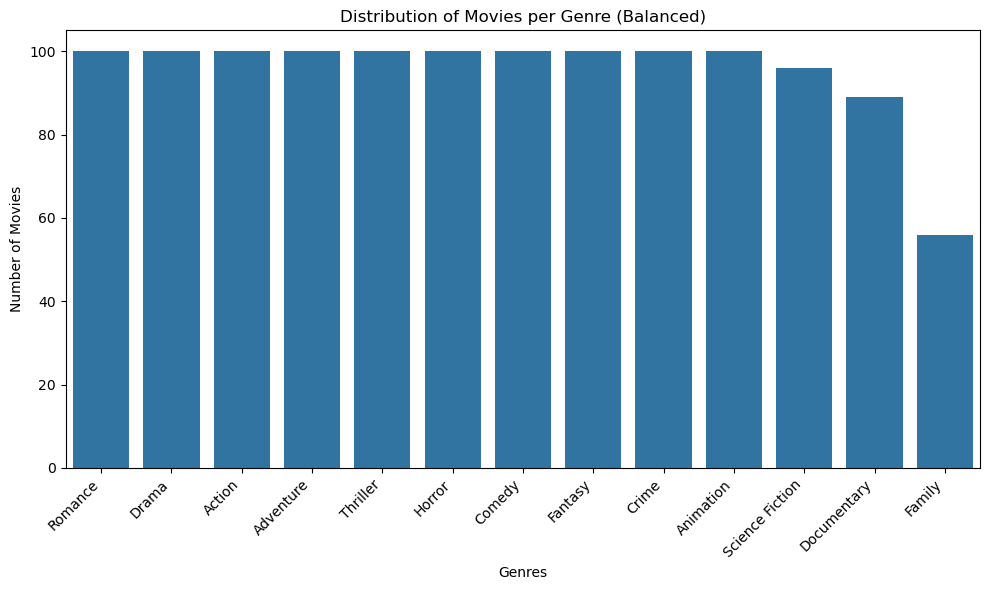

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
data = pd.read_csv("balanced_movies_downsampled.csv")

# Count the number of movies per genre
genre_counts = data["first_genre"].value_counts()

# Plot the genre distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values)
plt.xticks(rotation=45, ha="right")
plt.xlabel("Genres")
plt.ylabel("Number of Movies")
plt.title("Distribution of Movies per Genre (Balanced)")
plt.tight_layout()
plt.show()

## Cleaning Movie Metadata: Extracting Primary Genre and Overview for Text Classification


In [ ]:
import pandas as pd
import ast

data = pd.read_csv("balanced_movies_downsampled.csv")  # Load dataset

# Convert 'genres' column from string to a list of dictionaries
data["genres"] = data["genres"].apply(ast.literal_eval)

# Extract the first (primary) genre only
data["primary_genre"] = data["genres"].apply(
    lambda x: x[0]["name"] if isinstance(x, list) and len(x) > 0 else None
)

# Drop rows with missing overview or missing primary genre
data = data.dropna(subset=["overview", "primary_genre"])

# Keep only relevant columns
columns_to_keep = ["id", "title", "overview", "primary_genre"]
data = data[columns_to_keep]

# Print final dataset info
print(f"✅ Final dataset contains {len(data)} movies")
print(data.head())

✅ Final dataset contains 1238 movies
       id            title                                           overview  \
0   10288             Fido  Timmy Robinson's best friend in the whole wide...   
1   16323         The Rose  Midler is the rock-and-roll singer Mary Rose F...   
2   13197      10th & Wolf  A former street tough returns to his Philadelp...   
3     943  Lethal Weapon 3  Archetypal buddy cops Riggs and Murtaugh are b...   
4  366967      Dutch Kills  A desperate ex-con is forced to gather his old...   

  primary_genre  
0       Romance  
1         Drama  
2        Action  
3     Adventure  
4      Thriller  


In [ ]:
# --------------------  Text Feature Extraction -------------------- #
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_text = vectorizer.fit_transform(data['overview']).toarray()
print(f"✅ X_text shape: {X_text.shape}")

✅ X_text shape: (1238, 5000)


In [ ]:
# --------------------  Image Feature Extraction -------------------- #
# Load ResNet50 once (not in function to avoid reloading every time)
resnet = ResNet50(weights='imagenet', include_top=False, pooling='avg')

def extract_image_features(img_path):
    """Extracts deep image features using ResNet50"""
    try:
        img = image.load_img(img_path, target_size=(224, 224))  # Load image
        img_array = image.img_to_array(img)  # Convert to array
        img_array = np.expand_dims(img_array, axis=0)  # Expand dims to match ResNet input
        img_array = preprocess_input(img_array)  # Apply ResNet preprocessing

        features = resnet.predict(img_array)  # Get ResNet features
        return features.flatten()  # Flatten to 1D array
    except Exception as e:
        print(f"❌ Error processing {img_path}: {e}")
        return np.zeros(2048)  # Return zero vector if error occurs

# Test with an **actual** existing image path
sample_img_path = "posters/5.jpg"  # Make sure this image exists!
print(f"✅ Image features for '{sample_img_path}': {extract_image_features(sample_img_path).shape}")

# Load image features (assuming images are stored in 'posters/' folder)
image_paths = [f"posters/{id}.jpg" for id in data['id']]
X_image = np.array([extract_image_features(img) if os.path.exists(img) else np.zeros(2048) for img in image_paths])

print("✅ Final image feature shape:", X_image.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
✅ Image features for 'posters/5.jpg': (2048,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━

In [208]:
import joblib

# Save image features to disk
joblib.dump(X_image, "X_image_resnet50.pkl")

# (Optional) Save image IDs too
data['id'].to_csv("image_ids.csv", index=False)

In [16]:
import joblib

X_image = joblib.load("X_image_resnet50.pkl")
print(f"✅ Loaded X_image with shape: {X_image.shape}")

import pandas as pd

image_ids = pd.read_csv("image_ids.csv")
print(f"✅ Loaded {len(image_ids)} image IDs")

✅ Loaded X_image with shape: (1238, 2048)
✅ Loaded 1238 image IDs


## Label Encode Target


In [14]:
from sklearn.preprocessing import LabelEncoder

# Assume your original genre column is something like: 'primary_genre'
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data["primary_genre"])  # y will now be integer labels

## Train-Test Split


In [17]:
from sklearn.model_selection import train_test_split

X_train_text, X_test_text, X_train_image, X_test_image, y_train, y_test = train_test_split(
    X_text, X_image, y, test_size=0.2, random_state=42
)

## Train Models


In [18]:
from sklearn.ensemble import RandomForestClassifier

# Apply class weighting to handle class imbalance
text_model = RandomForestClassifier(n_estimators=500, random_state=42)
text_model.fit(X_train_text, y_train)

image_model = RandomForestClassifier(n_estimators=500, random_state=42)
image_model.fit(X_train_image, y_train)

RandomForestClassifier(n_estimators=500, random_state=42)

In [19]:
import joblib

# Save the model
joblib.dump(text_model, 'text_model.pkl')
joblib.dump(image_model, 'image_model.pkl')

['image_model.pkl']

In [20]:
import joblib


# Load it later
text_model = joblib.load('text_model.pkl')
image_model = joblib.load('image_model.pkl')

## Predict Probabilities and Fuse


In [21]:
# Predict probabilities
probs_text = text_model.predict_proba(X_test_text)   # shape: (n_samples, n_classes)
probs_image = image_model.predict_proba(X_test_image)

# Fuse by averaging
fused_probs = (probs_text + probs_image) / 2
fused_preds = np.argmax(fused_probs, axis=1)

# Individual predictions
y_pred_text = np.argmax(probs_text, axis=1)
y_pred_image = np.argmax(probs_image, axis=1)

# Evaluation


In [22]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

print("\n📊 Text Model")
print("Accuracy:", accuracy_score(y_test, y_pred_text))
print("F1 (macro):", f1_score(y_test, y_pred_text, average='macro'))

print("\n📊 Image Model")
print("Accuracy:", accuracy_score(y_test, y_pred_image))
print("F1 (macro):", f1_score(y_test, y_pred_image, average='macro'))

print("\n📊 Fused Model")
print("Accuracy:", accuracy_score(y_test, fused_preds))
print("F1 (macro):", f1_score(y_test, fused_preds, average='macro'))

# Optional: detailed report
print(classification_report(y_test, fused_preds, target_names=label_encoder.classes_))



📊 Text Model
Accuracy: 0.27419354838709675
F1 (macro): 0.26182411320967264

📊 Image Model
Accuracy: 0.2701612903225806
F1 (macro): 0.2257146479322407

📊 Fused Model
Accuracy: 0.34274193548387094
F1 (macro): 0.3163791655121003
                 precision    recall  f1-score   support

         Action       0.40      0.32      0.35        19
      Adventure       0.33      0.40      0.36        15
      Animation       0.57      0.61      0.59        28
         Comedy       0.26      0.47      0.34        19
          Crime       0.48      0.45      0.47        22
    Documentary       0.85      0.55      0.67        20
          Drama       0.16      0.12      0.14        24
         Family       0.00      0.00      0.00         7
        Fantasy       0.27      0.17      0.21        18
         Horror       0.29      0.32      0.30        19
        Romance       0.26      0.25      0.26        20
Science Fiction       0.32      0.35      0.33        20
       Thriller       0.09     

# Visualization


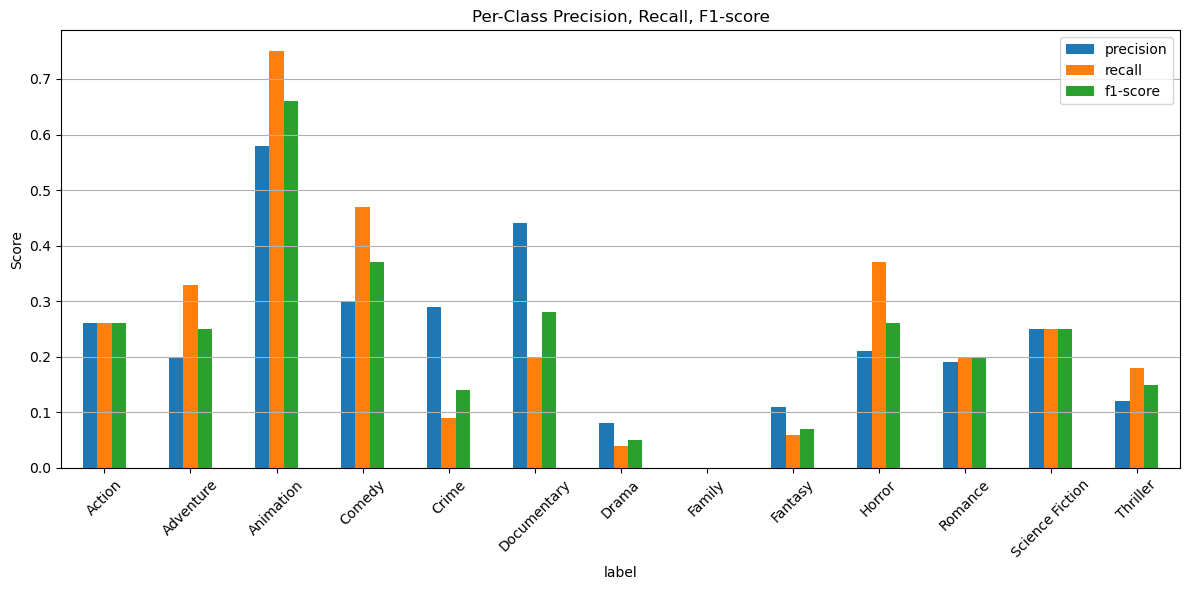

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

# Your data as a dictionary
data = {
    'label': ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Horror', 'Romance', 'Science Fiction', 'Thriller'],
    'precision': [0.26, 0.20, 0.58, 0.30, 0.29, 0.44, 0.08, 0.00, 0.11, 0.21, 0.19, 0.25, 0.12],
    'recall':    [0.26, 0.33, 0.75, 0.47, 0.09, 0.20, 0.04, 0.00, 0.06, 0.37, 0.20, 0.25, 0.18],
    'f1-score':  [0.26, 0.25, 0.66, 0.37, 0.14, 0.28, 0.05, 0.00, 0.07, 0.26, 0.20, 0.25, 0.15]
}

df = pd.DataFrame(data)
df.plot(x='label', kind='bar', figsize=(12, 6))
plt.title("Per-Class Precision, Recall, F1-score")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

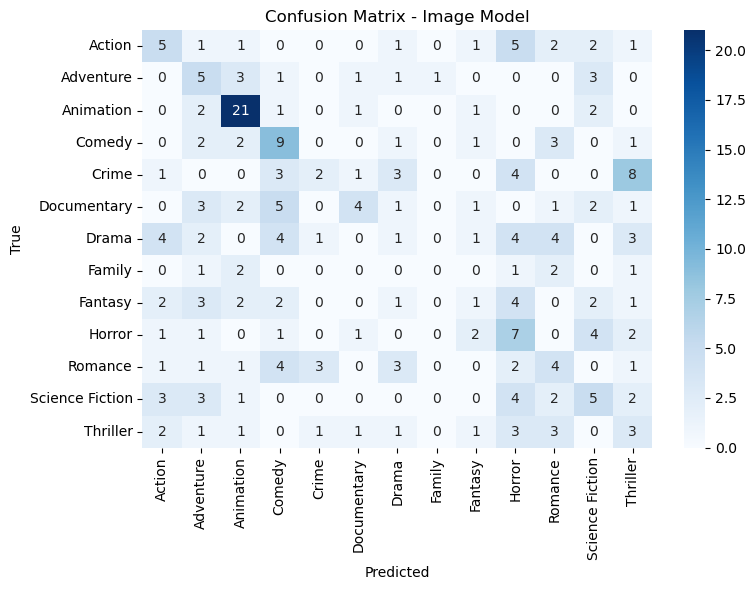

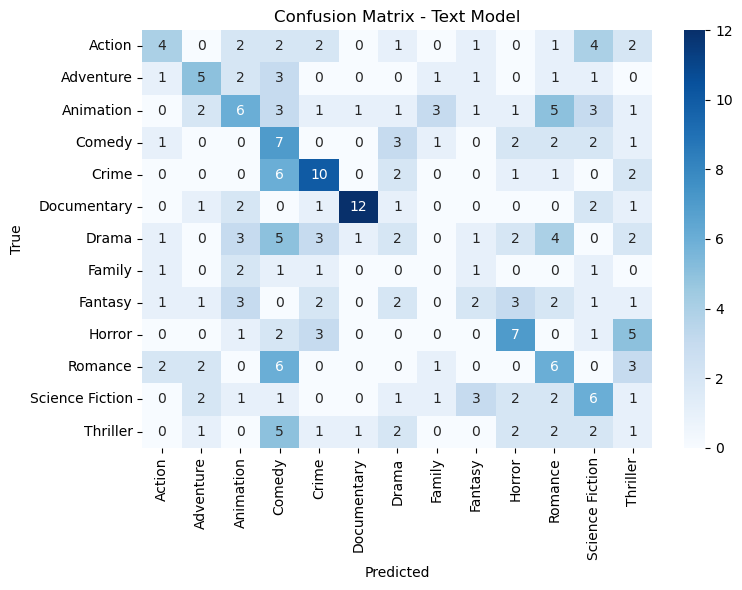

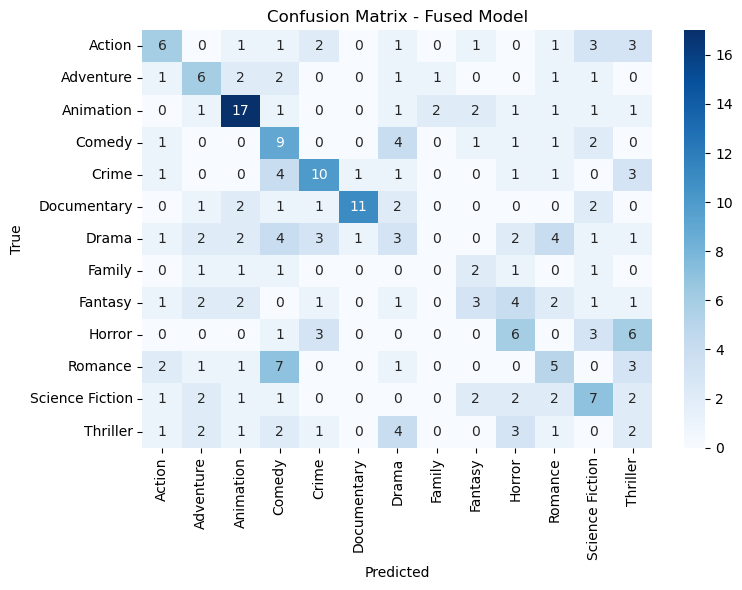

In [33]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrices
conf_matrix_img = confusion_matrix(y_test, y_pred_image)
conf_matrix_text = confusion_matrix(y_test, y_pred_text)
conf_matrix_fused = confusion_matrix(y_test, fused_preds)


import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_conf_matrix(cm, labels, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

labels = ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama',
          'Family', 'Fantasy', 'Horror', 'Romance', 'Science Fiction', 'Thriller']

plot_conf_matrix(conf_matrix_img, labels, "Confusion Matrix - Image Model")
plot_conf_matrix(conf_matrix_text, labels, "Confusion Matrix - Text Model")
plot_conf_matrix(conf_matrix_fused, labels, "Confusion Matrix - Fused Model")